In [ ]:
### Topic extraction and visualization using clustering, BERT and 


In [5]:
# !pip install umap-learn
# !pip install sklearn
# !pip install sentence_transformers
# !pip install hdbscan

In [173]:
import numpy as np 
import pandas as pd 
import hdbscan # this library will be used for clustering
import random



Identifying topics specific to clusters generated from UMAP.

Topic modeling is an unsupervised machine learning technique to automatically identify the "topics" that occur in a collection of documents.

There are various popular algorithms to identify topics in a document.

  One of the most apparochaes is LDA.  (very interesting paper that describes LDA https://www.cs.columbia.edu/~blei/papers/Blei2012.pdf)

* How can we use HuggingFace, specifically BERT Embedding, to derive topics inherent to a collection of documents?

The main topic of this article will not be the use of BERTopic but a tutorial on how to use BERT to create your topic model.



In [ ]:
#### 1. Getting the data

Dataset: 18000 posts, in 20 newsgroup topics. 
Run the following code cell

In [174]:
from sklearn.datasets import fetch_20newsgroups
download = fetch_20newsgroups(subset="all")


* Inspect the variable `download`. Extract the data contained in `download` and save it to a variable called `data`

In [ ]:
### Write your code here.


* Create a new variable called `data_subset` that contains 5k randomly selected instances. Use the `sample()` function from the `random` package.

In [10]:
data_subset = random.sample(data, 5_000)
len(data_subset)

5000


#### 2. Embeddings
* Use  'sentence-transformers' to convert the messages to embeddings.


In [13]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')


In [14]:
embeddings = model.encode(data_subset, show_progress_bar=True)
embeddings.shape

Batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:19<00:00,  1.97it/s]


(5000, 768)

#### 3. Dim. Reduction

We need to identify clusters in the data but input of 768 is too large. Therefore, we will use UMAP to lower the dimensionality of the daa

a UMAP instance can be constructed as follow. See the documentation for more details (https://umap-learn.readthedocs.io/en/latest/parameters.html)

```
umap_instnace = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='?')`
                            
```                            
* Which distnace do you think if most appropriate to use here?

* Reduce the dimensionality of the input to 5
  * Set the size of the local neighborhood to 15

* How can you determin a good value for the size of the local neighborhood?


In [132]:
import umap
umap_instance = umap.UMAP(n_neighbors=20, 
                            n_components=10, 
                            metric='cosine')


In [ ]:
Use the `fit_transform` method of `umap_instance` to change the dimensionality of the data

In [133]:
umap_embeddings = umap_instance.fit_transform(embeddings)
umap_embeddings.shape

(5000, 10)

* How could you normalize the vectors so they are all of the same magnitude?

In [134]:
# Write your code here
umap_embeddings.sum(axis=1).reshape(-1,1)
umap_embeddings /= umap_embeddings.sum(axis=1).reshape(-1,1)
umap_embeddings

array([[65.213554],
       [61.106087],
       [63.661343],
       ...,
       [64.143036],
       [65.39891 ],
       [65.36689 ]], dtype=float32)

#### 4. Cluster the Data Using HDBSCAN

* We don't know the number of inherent clusters, so let's use HDBSCAN; Hierarchical Density-Based Spatial Clustering of Applications with Noise. 

* You can read about HDBSCAN here, but essentially, to run it on HDBSCAN on the embeddings using the following:


In [136]:
import hdbscan
hdbscan_instance = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom')
clusters = hdbscan_instance.fit(umap_embeddings)


Knowing that the cluster labels for each input are stored in `clusters.labels_`. How many clusters are there and how many instances are in each cluster?

In [137]:
### Write your code here
from collections import Counter
print(set(clusters.labels_))

Counter(clusters.labels_)

Counter({15: 510,
         -1: 2705,
         1: 432,
         16: 116,
         14: 224,
         3: 215,
         7: 335,
         11: 64,
         9: 61,
         17: 52,
         13: 24,
         6: 27,
         8: 50,
         12: 31,
         10: 32,
         2: 26,
         4: 37,
         5: 24,
         0: 35})

* -1 refers to all documents that were not assigned to a cluster.

  * This is rather an advantage, not a drawback of HDBSCAAN

#### 5. Topic 
* To visualize the resulting clusters we can further reduce the dimensionality to 2.
* Plot the points in scatter plots
* Show the outliers as grey 

In [140]:
# import numpy as np
# import pandas as pd
# from IPython.display import display
# from tqdm import tqdm
# from collections import Counter
# import ast

# import matplotlib.pyplot as plt
# import matplotlib.mlab as mlab
# import seaborn as sb

# from sklearn.feature_extraction.text import CountVectorizer
# #from textblob import TextBlob
# import scipy.stats as stats

# from sklearn.decomposition import TruncatedSVD
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.manifold import TSNE


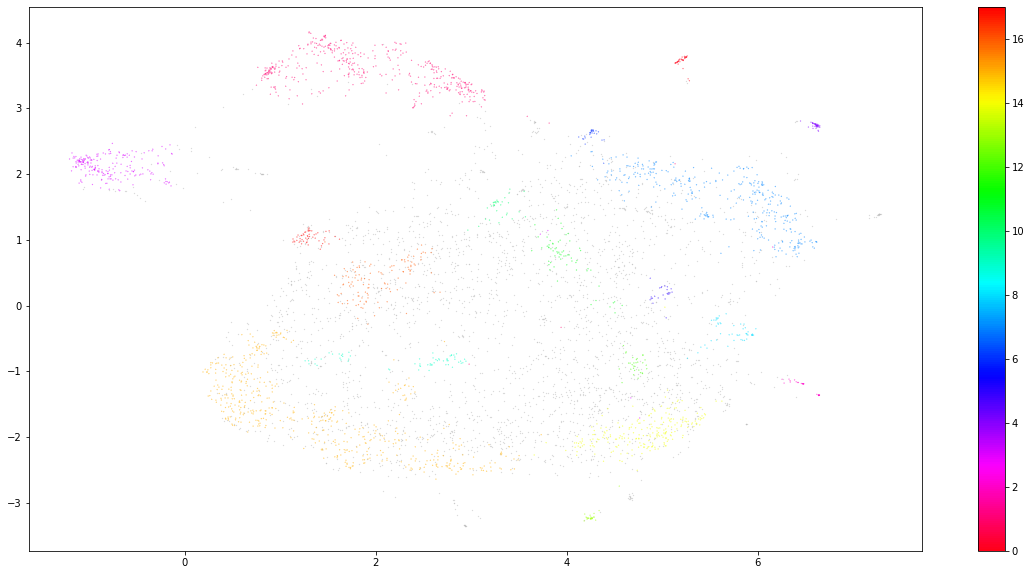

In [141]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = clusters.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [ ]:
K-means would work very well with the cosine the distnace. How do you find the best value of k?


## **4. Topic Creation**

* How can we derive topics from clustered documents?

  * We can use an apporach that is similar to that used in 2nd assignment. Namely, instead of treating each document as a catefority, concatenate all the docs in each cluster and identify words with high tf-idf values across clusters.


In [143]:
docs_df = pd.DataFrame(data_subset, columns=["Doc"])
docs_df['Topic'] = clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [160]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
tf_idf.shape

(72348, 19)

* Extract the most important 10 words for each topics based on the TF-IDF scores.
  * Remember that the higher the score, the more representative it should be of its topic as the score is a proxy of information density.

In [163]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/Users/mahdi/miniconda3/envs/s3-next/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Topic  Size
0      -1  2705
16     15   510
2       1   432
8       7   335
15     14   224
4       3   215
17     16   116
12     11    64
10      9    61
18     17    52

In [167]:
top_n_words[9]

[('bike', 0.046853400609794024),
 ('dod', 0.026902277681723954),
 ('helmet', 0.023491766384903662),
 ('805', 0.0207896821586093),
 ('ride', 0.018728220812845933),
 ('motorcycle', 0.018319791419502077),
 ('com', 0.017563091751919647),
 ('behanna', 0.0167186173262722),
 ('honda', 0.015198515442567086),
 ('bikes', 0.015072892991814607),
 ('riding', 0.014036176464971063),
 ('advice', 0.013964288031905135),
 ('ll', 0.013225056618111857),
 ('nec', 0.013129818397788838),
 ('714', 0.012659280969094402),
 ('jburnside', 0.012578543924892613),
 ('annual', 0.011840786600559662),
 ('ca', 0.01144709263163638),
 ('new', 0.011356482881653779),
 ('organization', 0.011328879090555884)]

**5. Topic Reduction**

Can we reduce the topics by merging the topic vectors that were most similar to each other.
  1. merge the most similar topics
  2. Re-calculate the TF-IDF vectors in each cluter

In [ ]:
!pip install cosine_similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [168]:
docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()

Topic   Doc  Doc_ID
0      -1  2705    2705
1      15   510     510
2       1   432     432
3       7   335     335
4      14   224     224
5       3   215     215
6      16   116     116
7      11    64      64
8       9    61      61
9      17    52      52
10      8    50      50
11      4    37      37
12      0    35      35
13     10    32      32
14     12    31      31
15      6    27      27
16      2    26      26
17     13    24      24
18      5    24      24

In [ ]:
for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [169]:
top_n_words[5]

[('cleveland', 0.05771063545363442),
 ('cwru', 0.039598355094682604),
 ('freenet', 0.03578791583054063),
 ('ins', 0.02856561295780083),
 ('reserve', 0.02791963036145006),
 ('mustang', 0.026385767731205163),
 ('aas7', 0.025110372631753607),
 ('western', 0.02465895903032776),
 ('previous', 0.02366706496933537),
 ('case', 0.02298209203229609),
 ('oh', 0.020557147991082655),
 ('tony', 0.019775247167513558),
 ('ch981', 0.01915007545673446),
 ('alicea', 0.01915007545673446),
 ('hela', 0.01907212031693593),
 ('spencer', 0.0189378732611986),
 ('says', 0.018784608918419963),
 ('po', 0.01810669487168666),
 ('camaro', 0.01788642202338807),
 ('usa', 0.017260006780108028)]


* Knowing that HDBSCAN has a complexity of $n^2$, what are the big-data-related bottlenecks of the above analysis? 
  * Describe in detail how you'd handle each bottleneck.
* What improvements would you make to the analysis above? Form an analytical perspective rather than a computational one.

* How would you handle instances assigned a -1 by HDBSCAN?
